In [1]:
# Need to scale problem better
# Need to include the cost function

In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('simplified_biped.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [LL] +\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias[base] for base in bases] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+[th_body] + [th[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [dx_body]+[dy_body]+[dth_body] + [dth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [ddx_body]+[ddy_body]+[ddth_body] + [ddth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body'] +['theta_body']

for leg in legs:
    for link in links:
        if 'foot' not in link:
            DOFs = DOFs + ['theta_{0}'.format(link+leg)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


In [3]:
# PARAMETERS:
masses_ = {'body': 2.06,
           'ullA': 0.31,
           'lllA': 0.53,
           'urlA': 0.31,
           'lrlA': 0.53,
           'footA': 0.07,
           'ullB': 0.31,
           'lllB': 0.53,
           'urlB': 0.31,
           'lrlB': 0.53,
           'footB': 0.07,
           'boom': 1.806}

lengths_ = {'body': 24/100,
            'ullA': 17.5/100,
            'lllA': 30.0/100,
            'urlA': 17.5/100,
            'lrlA': 30.0/100,
            'footA': 4.5/100,
            'ullB': 17.5/100,
            'lllB': 30.0/100,
            'urlB': 17.5/100,
            'lrlB': 30.0/100,
            'footB': 4.5/100,
            'boom': 0}

''' ****** '''
inertias_ = {'body': (masses_['body']*lengths_['body']**2)/12, # body rotate about its center 
            'ullA': (masses_['ullA']*lengths_['ullA']**2)/3, # rotates as pendulumn 
            'urlA': (masses_['urlA']*lengths_['urlA']**2)/3,
            'lllA': (masses_['lllA']*lengths_['lllA']**2)/3,
            'lrlA': (masses_['lrlA']*lengths_['lrlA']**2)/3,
            'footA': (masses_['footA']*lengths_['footA']**2)/3,
            'ullB': (masses_['ullB']*lengths_['ullB']**2)/3, # rotates as pendulumn 
            'urlB': (masses_['urlB']*lengths_['urlB']**2)/3,
            'lllB': (masses_['lllB']*lengths_['lllB']**2)/3,
            'lrlB': (masses_['lrlB']*lengths_['lrlB']**2)/3,
            'footB': (masses_['footB']*lengths_['footB']**2)/3,
            'boom': 0}

In [4]:
WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
legs = ['A','B']
links = ['ull','lll','url','lrl','foot']
bases = ['body','boom']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'ull' ,'right': 'url'}
all_links = []
for leg in legs:
    for link in links:
        all_links.append(link+leg)
        
[all_links.append(base) for base in bases]

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    
    for leg in legs:
        
#         [tau_value.update({(side,leg): BW*(m.tau_torque[n,'+ve',side,leg]-m.tau_torque[n,'-ve',side,leg])}) for side in sides]
#         [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
#         GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
#         GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

        [tau_value.update({(side,leg): BW*(m.tau_torque[n,'+ve',side,leg]-m.tau_torque[n,'-ve',side,leg])}) for side in sides]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list


<a id='time_step'></a>

In [5]:
N = 50
TT = 1.3

m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)


#Params--------------------------
m.g = Param(initialize = 9.81)
m.LL = Param(initialize = 7.5/100)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [6]:
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

In [7]:
''' CONSTRAINTS  - Integration'''
 
def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [8]:
# Variable of boom position
m.boom_position = Var(m.N, m.WDOFs)

# Get the boom position in WDOF
lamb_boom_position = {} 

[lamb_boom_position.update({WDOF: sym.lambdify(sym_list,r_bases['boom'][coordinates[WDOF]].simplify(),modules = [func_map])}) for WDOF in WDOFs]
    
def def_boom_position(m,n,wdof):
    var_list = get_var_list_zeros(m,n)
    return m.boom_position[n,wdof] == lamb_boom_position[wdof](*var_list)
m.def_boom_position = Constraint(m.N, m.WDOFs, rule = def_boom_position)


In [9]:
''' CONSTRAINTS  - CONNECTION POINT'''

m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.signs, m.WDOFs, m.legs, bounds = (0.0,None)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [10]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,foot_position[leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = 1,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,None)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,None)) # ground reaction forces
m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,None)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(foot_position[leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_friction_cone(m,n,leg):
    return m.friction_cone[n,leg] == m.mu*m.GRF_y[n,leg] - (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg])
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.ground_penalty[n,'contact',leg] == m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] 
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,leg):
    return m.ground_penalty[n,'friction',leg] == (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg]
m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,leg):
    return m.ground_penalty[n,'slip_+ve',leg] == m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg]
m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,leg):
    return m.ground_penalty[n,'slip_-ve',leg] == m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg]
m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

# bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


Text(0, 0.5, 'Torque (Nm)')

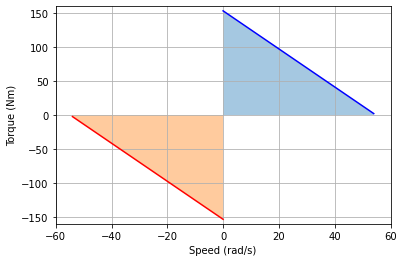

In [11]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
y_p = -2.8*x_p + 153.4
y_n = -2.8*x_n - 153.4

plt.grid()
plt.plot(x_p, y_p,'b')
plt.fill_between(x_p, y_p, alpha=0.4)

plt.plot(x_n, y_n,'r')
plt.fill_between(x_n, y_n, alpha=0.4)

plt.axis((-60,60,-160,160))
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')

In [12]:
# m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (0.0,38.0))

In [13]:
'''Constant Power - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.signs, m.sides, m.legs, bounds = (0.0,38.0))
m.tau_velocity = Var(m.N, m.signs, m.sides, m.legs, bounds = (0.0,46.0))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,'+ve',side,leg]-m.tau_velocity[n,'-ve',side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_constant_power(m,n,sign,side,leg):
    if sign == '+ve':
        return m.tau_torque[n,sign,side,leg] <= m.tau_velocity[n,sign,side,leg]*(-2.8) + 153.4
    else:
        return m.tau_torque[n,sign,side,leg] >= m.tau_velocity[n,sign,side,leg]*(-2.8) - 153.4
m.constant_power = Constraint(m.N, m.signs, m.sides, m.legs, rule = def_constant_power)

In [14]:
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,170*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side,leg] == 2*np.pi - m.q[n,'theta_lll'+leg]
    else:
        return m.knee_angle[n,side,leg] == m.q[n,'theta_lrl'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

<a id='initial_conditions'></a>

In [15]:
''' Use this code for tests '''

tests = ["High_Drop_Test","Low_Drop_Test","Hop_Test","Drop_Hop_Test"]

test = tests[2]

# BOUND VALUES

for n in range(1,N+1):
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test":
        [m.tau_torque[n,sign,side,leg].fix(0.0) for side in sides for sign in signs for leg in legs]
    
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = 0.0
        y_high_lim = 2.0
    
        m.q[n,'theta_body'].setub(np.pi*(1/3))
        m.q[n,'theta_body'].setlb(np.pi*(-1/3))

        sign_symbols = ['+','-']
        boundaries = ['setub','setlb']

        for leg in legs:
            for dof in DOFs:
                m.dq[1,dof].fix(0.0)
            for index in range(len(boundaries)):
                eval('m.q[n,\'theta_ull\'+leg].{0}(np.pi*(0.5{1}1/3))'.format(boundaries[index],sign_symbols[index]))
                eval('m.q[n,\'theta_lll\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
                eval('m.q[n,\'theta_url\'+leg].{0}(np.pi*(0.5{1}1/3))'.format(boundaries[index],sign_symbols[index]))    
                eval('m.q[n,\'theta_lrl\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))
    
    else:
        [m.tau_torque[1,sign,side,leg].fix(0.0) for side in sides for sign in signs for leg in legs]
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = 0.0
        y_high_lim = 1.5
        
        m.q[n,'theta_body'].setub(np.pi*(1/3))
        m.q[n,'theta_body'].setlb(np.pi*(-1/3))

        sign_symbols = ['+','-']
        boundaries = ['setub','setlb']

        for leg in legs:
            for dof in DOFs:
                m.dq[1,dof].fix(0.0)
            for index in range(len(boundaries)):
                eval('m.q[n,\'theta_ull\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
                eval('m.q[n,\'theta_lll\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
                eval('m.q[n,\'theta_url\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
                eval('m.q[n,\'theta_lrl\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))

if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.3)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
#     m.foot_position[1, 'Y', 'A'].fix(1.0)
#     m.foot_position[1, 'Y', 'B'].fix(1.0)

    for leg in legs:
        if leg == 'A':
            m.q[1,'theta_ull'+leg].fix(np.pi*(0.5-1/5))
            m.q[1,'theta_url'+leg].fix(np.pi*(0.5+1/5))
        else:
            m.q[1,'theta_ull'+leg].fix(np.pi*(0.5-1/7))
            m.q[1,'theta_url'+leg].fix(np.pi*(0.5+1/7))
        
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.3)
    m.foot_position[1, 'Y', 'B'].fix(0.33)
    m.foot_position[1, 'X', 'A'].fix(0.0)
    m.foot_position[1, 'X', 'B'].fix(0.0)

#     for leg in legs:
#         m.q[1,'theta_ull'+leg].fix(np.pi*(0.5-1/10))
#         m.q[1,'theta_url'+leg].fix(np.pi*(0.5+1/10))
        
elif test == "Hop_Test":
    #  ----------------------------- HOP TEST ---------------------------

    # initial condition
    m.q[1,'y_body'].fix(0.35)
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.0)
    m.foot_position[1, 'Y', 'B'].fix(0.0)
    m.foot_position[1, 'X', 'A'].fix(-0.2)
    m.foot_position[1, 'X', 'B'].fix(0.2)
        
    m.q[N,'y_body'].setlb(0.8)

# elif test == "Drop_Hop_Test":
    
#     # initial condition
#     m.q[1,'x_body'].fix(0.5)
#     m.q[1,'theta_body'].fix(np.pi*(0.0))
#     m.q[1,'theta_ullA'].fix(np.pi*(0.5-0.1))
#     m.q[1,'theta_urlA'].fix(np.pi*(0.5+0.1))
#     # m.foot_position[1, 'Y', 'A'].fix(0.3)
        
#     m.foot_position[round(N/5), 'Y', 'A'].setub(0.05)
#     m.foot_position[N, 'Y', 'A'].setlb(0.3)
    
# #     m.q[round(N/4),'y_body'].setub(0.4)
#     m.q[N,'x_body'].setub(0.7)
#     m.q[N,'x_body'].setlb(0.3)
    
else: pass

In [16]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    # T = sum(m.h[n] for n in range(1,N+1)) # minimum time
    tau_sum = 0
    pen_sum = 0
    T = sum(m.h[n] for n in range(1,N+1))
    for n in range(1,N+1):
        for leg in legs:
            for side in sides:
                tau_sum = tau_sum + (m.tau_torque[n,'+ve',side,leg]-m.tau_torque[n,'-ve',side,leg])**2 
            for gc in ground_constraints:
                pen_sum += m.ground_penalty[n,gc,leg] 
    return T +(10^3)*pen_sum # + tau_sum
m.Cost = Objective(rule = CostFun)

In [17]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_ullA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullA'](*var_list) == 0
m.EOM_th_ullA_constraint = Constraint(m.N, rule = EOM_th_ullA)

def EOM_th_lllA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllA'](*var_list) == 0
m.EOM_th_lllA_constraint = Constraint(m.N, rule = EOM_th_lllA)

def EOM_th_urlA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlA'](*var_list) == 0
m.EOM_th_urlA_constraint = Constraint(m.N, rule = EOM_th_urlA)

def EOM_th_lrlA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlA'](*var_list) == 0
m.EOM_th_lrlA_constraint = Constraint(m.N, rule = EOM_th_lrlA)

In [18]:
def EOM_th_ullB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullB'](*var_list) == 0
m.EOM_th_ullB_constraint = Constraint(m.N, rule = EOM_th_ullB)

def EOM_th_lllB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllB'](*var_list) == 0
m.EOM_th_lllB_constraint = Constraint(m.N, rule = EOM_th_lllB)

def EOM_th_urlB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlB'](*var_list) == 0
m.EOM_th_urlB_constraint = Constraint(m.N, rule = EOM_th_urlB)

def EOM_th_lrlB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlB'](*var_list) == 0
m.EOM_th_lrlB_constraint = Constraint(m.N, rule = EOM_th_lrlB)

In [19]:
# solving
opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000    # maximum number of iterations
opt.options["max_cpu_time"] = 600  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

Ipopt 3.14.5: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    23586
Number of nonzeros in inequality constraint Jacobian.:      792
Number of nonzeros in Lagrangian Hessian.............:    10666

Total number of variables............................:     4768
                     variables with only lower bounds:     1395
                variables with lower and upper bounds:     1491
                     variables with only upp

  99r 2.7377254e+03 7.24e-01 6.98e+02  -3.8 1.41e+02  -2.2 1.83e-02 6.08e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 2.7724282e+03 7.14e-01 6.97e+02  -3.8 5.07e+01  -1.8 1.52e-02 1.76e-02f  1
 101r 2.9087760e+03 6.82e-01 6.86e+02  -3.8 1.04e+02  -1.4 3.31e-04 4.41e-02f  1
 102r 2.9120164e+03 6.58e-01 6.66e+02  -3.8 1.96e+00  -0.0 7.74e-03 3.51e-02f  1
 103r 2.9413358e+03 6.32e-01 6.22e+02  -3.8 1.18e+01  -0.5 1.95e-01 3.97e-02f  1
 104r 2.9694797e+03 5.04e-01 5.14e+02  -3.8 2.44e+00  -0.1 8.38e-02 2.02e-01f  1
 105r 3.0364560e+03 4.72e-01 4.78e+02  -3.8 1.84e+01  -0.6 1.34e-01 6.25e-02f  1
 106r 3.0732317e+03 3.83e-01 4.17e+02  -3.8 3.45e+00  -0.1 1.63e-02 1.89e-01f  1
 107r 3.0732139e+03 3.82e-01 4.15e+02  -3.8 4.61e+00   0.3 3.74e-03 2.22e-04h  1
 108r 3.0711296e+03 3.50e-01 3.72e+02  -3.8 5.39e-01   0.7 2.60e-01 8.60e-02f  1
 109r 3.0699401e+03 3.50e-01 3.76e+02  -3.8 8.34e+00   0.2 9.20e-03 8.30e-03f  1
iter    objective    inf_pr 

 226r 9.4800856e+03 4.96e-02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 8.21e-08R  2
 227r 9.8180423e+03 7.07e-03 9.69e+02  -1.0 5.13e+01    -  1.69e-02 5.49e-02f  1
 228r 9.8240603e+03 7.07e-03 1.02e+03  -1.0 6.56e+00    -  1.11e-01 4.04e-03f  1
 229r 1.0033351e+04 7.06e-03 7.63e+02  -1.0 5.77e+00    -  1.06e-01 2.68e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 1.0277475e+04 7.06e-03 6.14e+02  -1.0 3.96e+00    -  1.97e-01 3.11e-01f  1
 231r 1.1111384e+04 2.34e-01 9.04e+02  -1.0 5.54e+00    -  1.14e-01 1.00e+00f  1
 232r 1.1181656e+04 1.80e-01 6.00e+02  -1.0 1.20e+00   0.0 3.37e-01 3.36e-01f  1
 233r 1.1552386e+04 8.80e-01 6.16e+02  -1.0 1.75e+00  -0.5 2.23e-01 1.00e+00f  1
 234r 1.1647651e+04 6.52e-01 5.34e+02  -1.0 1.11e+00  -0.1 9.87e-02 6.50e-01f  1
 235r 1.1688701e+04 1.34e-01 4.29e+02  -1.0 6.70e+00  -0.5 1.36e-01 1.61e-01f  1
 236r 1.1899918e+04 1.84e-01 3.44e+02  -1.0 1.62e+00  -1.0 1.66e-01 5.90e-01f  1
 237r 1.1898943e+04 1.69e-01

In [20]:
print(results.solver.termination_condition) # check if optimal

infeasible


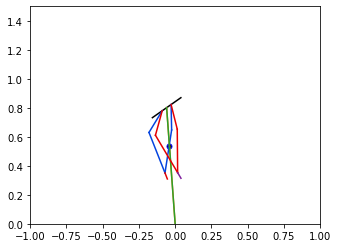

In [21]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_url = {}
    plot_lrl = {}
    plot_ull = {}
    plot_lll = {}
    plot_foot = {}
    abs_angles = {}
    
    # plot boom
    ax.plot(m.boom_position[i,'X'].value, m.boom_position[i,'Y'].value, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="black")

    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    for leg in legs:
        if leg == 'A':
            link_colour = ['blue','red']
        else:
            link_colour = ['red','purple']
        
        ax.plot([0,m.q[i,'x_body'].value],[0,m.q[i,'y_body'].value]) # plot the boom
        
        #plot upper right
        abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
        plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
        plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
        plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
        plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
        plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
        plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
        plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
        plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
        plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
        plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot foot
        mu = 150*(np.pi/180) 
        plot_foot.update({('top','X',leg): plot_lll['bot','X',leg]})
        plot_foot.update({('top','Y',leg): plot_lll['bot','Y',leg]})
        plot_foot.update({('bot','X',leg): plot_foot['top','X',leg] + m.lengths['foot'+leg]*cos(mu-abs_angles['RL',leg])})
        plot_foot.update({('bot','Y',leg): plot_foot['top','Y',leg] - m.lengths['foot'+leg]*sin(mu-abs_angles['RL',leg])})
        ax.plot([plot_foot['top','X',leg],plot_foot['bot','X',leg]],[plot_foot['top','Y',leg],plot_foot['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[1]))
        
    ax.plot([-10,10],[-10,-10]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [22]:
f = r"{0}_biped.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 
len(N_time)

102

ValueError: x and y must have same first dimension, but have shapes (102,) and (204,)

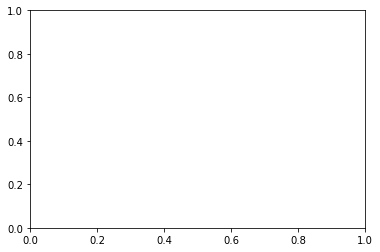

In [23]:
dd_ullA_plot = []
dd_yb_plot = []
GRF_Y_plot = []
left_knee = []
right_knee = []
left_torque = []

for n in N_time:
    for leg in legs:
        GRF_Y_plot.append(m.GRF_y[n,'A'].value)
        dd_ullA_plot.append(m.ddq[n,'theta_urlA'].value)
        dd_yb_plot.append(m.ddq[n,'y_body'].value)
        left_knee.append(2*np.pi - m.q[n,'theta_lll'+leg].value)
        left_torque.append(m.tau_torque[n,'+ve','left','A'].value-m.tau_torque[n,'-ve','left','A'].value)
    
# plt.plot(N_time[2:],dd_ullA_plot[2:])
plt.plot(N_time[:],GRF_Y_plot[:])
# plt.figure()
# plt.plot(N_time,right_tau)

In [ ]:
print(results.solver.termination_condition) # check if optimal

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step'</a>